In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Chandra files

In [9]:
w, b, f, e1, e2 = np.loadtxt('Chandra/GJ699all_spectrum.dat', skiprows=3, unpack=True)

<ErrorbarContainer object of 3 artists>

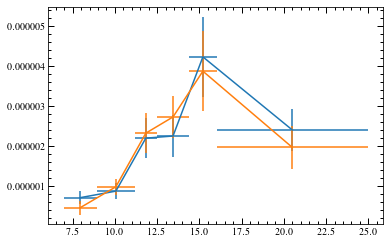

In [13]:
plt.errorbar(w, f, xerr=b, yerr=e1)
plt.errorbar(w, e2, xerr=b, yerr=e1)

In [14]:
w, b, f, e1, e2 = np.loadtxt('Chandra/GJ699quiet_spectrum.dat', skiprows=3, unpack=True)

<ErrorbarContainer object of 3 artists>

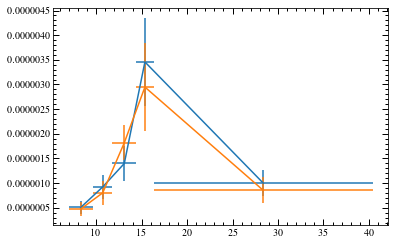

In [15]:
plt.errorbar(w, f, xerr=b, yerr=e1)
plt.errorbar(w, e2, xerr=b, yerr=e1)

In [16]:
lya = Table.read('lya/GJ699_G140M_intrinsic_lya_profile.txt', format='ascii')

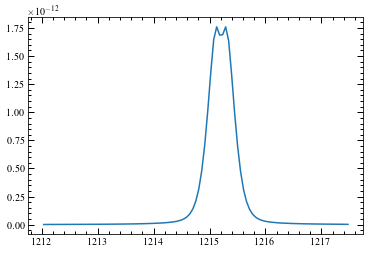

In [18]:
plt.plot(lya['wave'], lya['intrinsic_lya'])

In [20]:
savedat= Table([lya['wave'], lya['intrinsic_lya']], names=['WAVELENGTH', 'FLUX'])
savedat.write('lya/GJ699_lya_simple.txt', format='ascii')

In [21]:
mw, mb, mf = np.loadtxt('Chandra/GJ699all_model.dat', skiprows=3, unpack=True)

<ErrorbarContainer object of 3 artists>

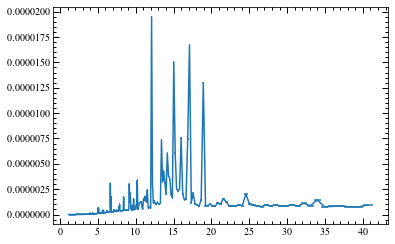

In [22]:
plt.errorbar(mw, mf, xerr=mb)

In [23]:
chandra_path = '/home/david/work/muscles/MegaMUSCLES/GJ_699/Chandra/primary/'

In [24]:
cfiles = os.listdir(chandra_path)
cfiles

['acisf20619_000N001_fov1.fits.gz',
 'acisf20619N001_cntr_img2.jpg.gz',
 'acisf20619N001_cntr_img2.fits.gz',
 'acisf20619_000N001_bpix1.fits.gz',
 'pcadf677149624N001_asol1.fits.gz',
 'orbitf677073905N001_eph1.fits.gz',
 'acisf20619N001_full_img2.jpg.gz',
 'acisf20619N001_evt2.fits.gz',
 'acisf20619N001_full_img2.fits.gz']

In [25]:
evts = fits.open(chandra_path+'acisf20619N001_evt2.fits.gz')

In [26]:
evts.info()

Filename: /home/david/work/muscles/MegaMUSCLES/GJ_699/Chandra/primary/acisf20619N001_evt2.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  EVENTS        1 BinTableHDU    838   32749R x 19C   [1D, 1I, 1I, 1J, 1I, 1I, 1I, 1I, 1E, 1E, 1E, 1E, 1J, 1J, 1E, 1J, 1I, 1I, 32X]   
  2  GTI           7 BinTableHDU     28   1R x 2C   [1D, 1D]   


In [27]:
evts[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDUNAME = 'PRIMARY '                                                            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'ASC     '           / Source of FITS file                            
CREATOR = 'cxc - Version DS10.7' / tool that created this output                
CHECKSUM= 'UmiBajiAVjiAajiA'   / HDU checksum updated 2019-06-17T22:22:12       
DATASUM = '        '        

In [29]:
from astropy.time import Time

In [30]:
hdr = evts[0].header

In [31]:
hdr['TSTOP'] -hdr['TSTART']

30385.61431992054

In [36]:
times = Time([hdr['DATE-OBS'], hdr['DATE-END']])
times

<Time object: scale='utc' format='isot' value=['2019-06-17T08:52:14.000' '2019-06-17T17:18:39.000']>

In [40]:
np.diff(times)[0].to(u.s)

<Quantity 30385. s>

In [47]:
tstart = Time(hdr['DATE-OBS'])
tend = Time(hdr['DATE-END'])
exptime = (tend-tstart).to(u.s)
print(tstart, tend, exptime)


2019-06-17T08:52:14.000 2019-06-17T17:18:39.000 30385.000000000004 s


In [49]:
w, b, f, e1, e2 = np.loadtxt('Chandra/all/GJ699all_spectrum.dat', skiprows=3, unpack=True)

<ErrorbarContainer object of 3 artists>

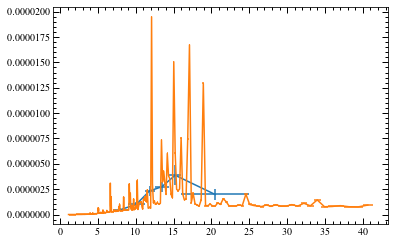

In [52]:
#plt.errorbar(w, f, xerr=b, yerr=e1)
plt.errorbar(w, e2, xerr=b, yerr=e1)
plt.errorbar(mw, mf, xerr=mb)

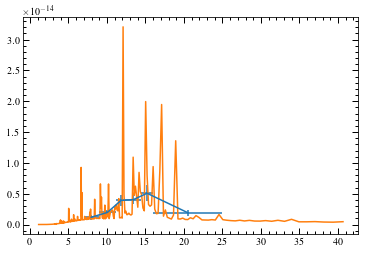

In [58]:
fn = [fi*1.99e-8/wi for fi, wi in zip(e2,w)]
en = (e1/e2)*fn
plt.errorbar(w, fn, xerr=b, yerr=en)

mfn = [fi*1.99e-8/wi for fi, wi in zip(mf,mw)]
plt.plot(mw, mfn)


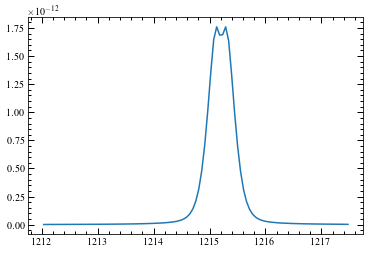

In [59]:
plt.plot(lya['wave'], lya['intrinsic_lya'])

In [60]:
wl, fl = lya['wave'], lya['intrinsic_lya']


In [61]:
mask = (wl > 1214) & (wl < 1217)
np.trapz(fl[mask], wl[mask])

1.039869917054704e-12

In [62]:
np.trapz(fl, wl)

1.0500816791979071e-12

In [63]:
evts[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   64 / width of table in bytes                        
NAXIS2  =                32749 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   19 / number of fields in each row                   
EXTNAME = 'EVENTS  '           / name of this binary table extension            
HDUNAME = 'EVENTS  '           / ASCDM block name                               
TTYPE1  = 'time    '           / S/C TT corresponding to mid-exposure           
TFORM1  = '1D      '           / format of field                                
TUNIT1  = 's       '        

In [64]:
evts[2].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   16 / width of table in bytes                        
NAXIS2  =                    1 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
EXTNAME = 'GTI     '           / name of this binary table extension            
EXTVER  =                    7                                                  
HDUNAME = 'GTI7    '           / ASCDM block name                               
TTYPE1  = 'START   '           / S/C TT corresponding to mid-exposure           
TFORM1  = '1D      '        